# Doubly constrained gravity model

For a given:
* set of origins $i$ and destinations $j$ 
* production at origins vector $O_i$
* attraction at destinations vector $D_j$
* distance (cost) matrix between origins and destinations $C_{ij}$
* cost function for the decay/gravity function $T_{ij}=exp(-\beta C_{ij})$

Compute:
* trip matrix $T_{ij}$ such that
* $\sum_{i \in O} T_{ij} = O_i \forall j \in O$
* $\sum_{j \in D} T_{ij} = D_i \forall i \in D $


In [1]:
import osmnx as ox
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

let's import some network - nodes are zones of the network

In [4]:
G = ox.graph_from_place('Strzyzow, Poland', network_type='drive')

/opt/anaconda3/envs/ExMAS/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/opt/anaconda3/envs/ExMAS/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/opt/anaconda3/envs/ExMAS/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


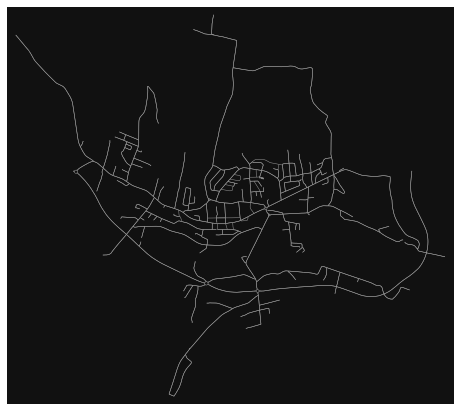

In [90]:
_ = ox.plot_graph(G,node_size=0, edge_linewidth=0.5)

compute the distance matrix between nodes (this is gonna be our cost matrix $C_{ij}$

In [92]:
skim = dict(nx.all_pairs_dijkstra_path_length(G, weight = 'length')) # compute skim

In [91]:
C = pd.DataFrame(skim).dropna()
C = C.reset_index(drop=True).T.reset_index(drop=True).T # index nodes incrementally
C=(C/1000).round(2) # to kilometers

In [161]:
def doubly_constrained(O, D, C, beta = 0.1, plot = True, max_ite = 10000, eps = 0.01):
    """
    Computes trip matrix
    O - pandas series of origin flow from each zone
    D - pandas series of destination flows towards each zone
    C - cost matrix (distance) between the zones (pd.DataFrame)
    beta - parameter in the gravity model (enters with negative sign into the model)
    plot - flag to print iterations and plot results on the graphs
    max_ite - maximal number of iterations
    eps - error (Total Squared error) at which balancing terminates
    """
    def fun(x):
        return np.exp(-beta*x)
    O = O.values # rows
    A = np.ones_like(O)
    D = D.values # columns
    B = np.ones_like(D)
    F = C.apply(np.vectorize(fun))
    for i in range(max_ite):
        T = np.outer(O*A,D*B)*F
        A = np.reciprocal((B*D*F).sum(1))
        T = np.outer(O*A,D*B)*F       
        B = np.reciprocal((A*O*(F.T)).sum(1))
        if max(((T.sum(1)-O)**2).sum(),((T.sum(0)-D)**2).sum()) < eps:
            break
        if plot and i % 1 ==0:
            print("Iteration: {}\t total: {:.2f}\t error_O: {:.2f}\t error_D: {:.2f}".format(i,
                                                                             T.sum().sum(),
                                                                             ((T.sum(1)-O)**2).sum(),
                                                                             ((T.sum(0)-D)**2).sum()))
            
    H = T.stack().to_frame()
    H.columns = ['flow']
    H['cost'] = C.stack()
    mean_cost = (H.cost*H.flow).sum()/H.flow.sum()
    cost_var = (H.cost*H.flow).std()
    print("Ite: {}\t demand:{:.2f}\t trips: {:.2f}\t error_O: {:.2f}\t error_D: {:.2f} cost mean: {:.2f}\t var: {:.2f}".format(i,
                                                                                                                               O.sum(),
                                                                                                                               T.sum().sum(),
                                                                                                                               ((T.sum(1)-O)**2).sum(),
                                                                                                                               ((T.sum(0)-D)**2).sum(),
                                                                                                                               mean_cost, cost_var))
    if plot:
        fig, axes = plt.subplots(1,4,figsize = (15,5))
        axes = axes.flatten()
        #productions
        ((T.sum(1)-O)/O).hist(ax=axes[0]) # error at origins
        axes[0].set_title('Error at origins deistibution')
        ((T.sum(0)-D)/D).hist(ax=axes[1]) # error at destinations
        axes[1].set_title('Error at destinations deistibution')
        H['flow'].plot(kind='hist', weights = H['cost'], ax = axes[2], bins = 30) # trip distance distribution
        axes[2].set_title('Trip distance distribution')
        
        
        x=np.linspace(C.min().min(),C.max().max(), 200)
        axes[3].plot(x,fun(x))
        axes[3].set_title('Theoretical impedance')

    return T

Iteration: 0	 total: 18072.00	 error_O: 0.00	 error_D: 39221.80
Iteration: 1	 total: 18072.00	 error_O: 0.00	 error_D: 6.90
Ite: 2	 demand:18072.00	 trips: 18072.00	 error_O: 0.00	 error_D: 0.01 cost mean: 1.70	 var: 0.26


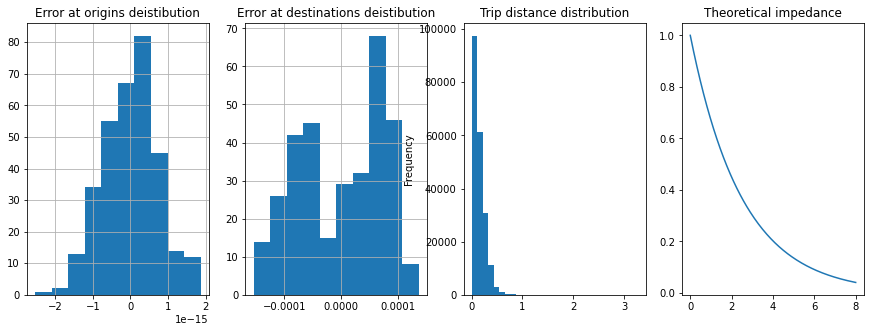

In [162]:
O = np.random.randint(10,100,size=C.shape[0])
D = O.copy()
np.random.shuffle(D)
#C = pd.DataFrame(np.random.randint(10,20,size=(size,size)))
#for beta in range(1,100):
#    T = mine(pd.Series(O), pd.Series(D), C, beta = beta/5, plot = False)
T = doubly_constrained(pd.Series(O), pd.Series(D), C, beta = 0.4, plot = True)

In [163]:
T

,0,1,2,3,4,5,6,7,8,9,...,315,316,317,318,319,320,321,322,323,324
0,1.934634,0.301929,0.308656,0.441398,0.435313,0.815167,0.266492,0.877519,0.168816,0.133886,...,0.660122,0.277626,0.623207,0.036454,0.212433,0.052732,0.098270,0.088532,0.498771,0.188602
1,0.954946,0.149034,0.152354,0.218750,0.214873,0.403984,0.132069,0.433148,0.083329,0.066087,...,0.325840,0.137587,0.307618,0.017994,0.104858,0.026029,0.048701,0.043700,0.246196,0.093095
2,0.910029,0.142024,0.145188,0.208461,0.204766,0.384982,0.125857,0.412774,0.079409,0.062978,...,0.310514,0.131115,0.293149,0.017148,0.099926,0.024804,0.046410,0.041645,0.234616,0.088716
3,0.478174,0.074626,0.076289,0.109098,0.107594,0.201481,0.065868,0.216892,0.041725,0.033092,...,0.163159,0.068619,0.154035,0.009010,0.052506,0.013033,0.024289,0.021882,0.123279,0.046616
4,1.787743,0.277890,0.284082,0.407884,0.402261,0.753274,0.246258,0.807654,0.155998,0.123226,...,0.610001,0.256546,0.575888,0.033686,0.196303,0.048533,0.090808,0.081484,0.460901,0.173586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,0.095326,0.117662,0.038469,0.055013,0.054255,0.092298,0.022988,0.099358,0.019114,0.015159,...,0.082274,0.034602,0.077673,0.011914,0.073718,0.018081,0.032244,0.028588,0.066273,0.086944
321,0.205977,0.419172,0.092974,0.132958,0.137573,0.199434,0.049473,0.214688,0.041302,0.032756,...,0.211985,0.088090,0.196954,0.057521,0.354502,0.086947,0.155059,0.137477,0.319973,0.179062
322,0.048228,0.093546,0.029859,0.042871,0.044359,0.046883,0.011630,0.050267,0.009670,0.007669,...,0.068353,0.028291,0.063506,0.018547,0.114307,0.028036,0.049998,0.044329,0.102761,0.039961
323,0.243757,0.472807,0.151521,0.216685,0.224205,0.236960,0.058782,0.254066,0.049073,0.038919,...,0.345476,0.142989,0.320979,0.093743,0.577739,0.141700,0.252702,0.224049,0.521466,0.201974


----
(c) Rafal Kucharski, 2022